In [1]:
!hostname

gnode001.cluster


In [2]:
!nvidia-smi

Mon Nov 28 12:20:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  Off  | 00000000:17:00.0 Off |                    0 |
| N/A   25C    P0    32W / 250W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import itertools as it
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sdeint
from toolbox import (
    make_loss,
    StatLoss,
    SINN,
    FPU
)

In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device('cuda')

In [6]:
print(torch.__version__)
print(torch.version.cuda)

1.13.0+cu117
11.7


200.0
(1500, 400) (1500, 400)
(400, 400) (400, 400) (400, 400)
(400, 400, 2)
CPU times: user 775 ms, sys: 28.2 ms, total: 803 ms
Wall time: 931 ms


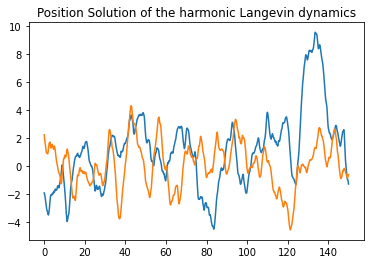

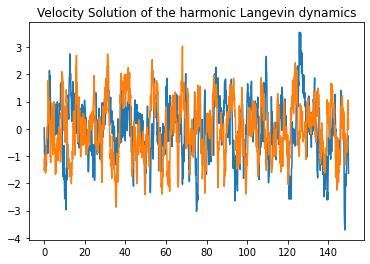

In [7]:
%%time

#### Generating SINN training data by solving SDE (Langevin dynamics)
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad



#### Parameters 
gamma = 1                              # coupling constant 
beta = 1                               # Inverse temperature, i.e. T=1/beta
dt = 0.01                              # Step-size of the SDE solver 
delta_t = 0.1                          # Step-size of the temporally coarse-grained path
batch = 400                            # Batch size 
sec_length = 400                       # Length of the input sequence 
k = .2                                # Constant factor characteristic of the spring (stiffness) try .2, .25 and .5

#### SDE solver (EM scheme) 
Time = 5*delta_t*sec_length
print(Time)
length=int(Time/dt)+1
t = np.linspace(0,Time,length) # define time axis
gap=int(delta_t/dt)
t_store=t[0:-1:gap]
p_store = np.zeros([t_store.size+1,batch])
q_store = np.zeros([t_store.size+1,batch])
p=np.zeros((2,batch))
q=np.zeros((2,batch))
# solve SDE
j=1
for i in range(1,length):
     q[1,:] = q[0,:] + p[0,:]*dt
     p[1,:] = p[0,:] + (-k*q[0,:]-gamma*p[0,:])*dt + np.random.randn(1,batch)*np.sqrt(2*dt*gamma/beta)
     if i % gap ==0:            
            p_store[j,:]=p[1,:]
            q_store[j,:]=q[1,:]
            j=j+1
     p[0,:]=p[1,:]
     q[0,:]=q[1,:]

Toss=int(t_store.size/4)
p_store=p_store[Toss:-1,:]          
q_store=q_store[Toss:-1,:]         
print(p_store.shape,q_store.shape)



plt.figure(1)
for i in range(2):
    plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,i])
# plt.legend()
plt.title("Position Solution of the harmonic Langevin dynamics")
# plt.savefig("figs/FPU_dt016.pdf", dpi=150)

plt.figure(2)
for i in range(2):
    plt.plot(t_store[Toss:]-t_store[Toss],p_store[:,i])
# plt.legend()
plt.title("Velocity Solution of the harmonic Langevin dynamics")


# Construct the sample traj for SINN learning 
ini=np.random.randn(sec_length,batch)
Traj_q=q_store[0:sec_length,:]
Traj_p=p_store[0:sec_length,:]
print(ini.shape, Traj_q.shape, Traj_p.shape)

Traj = np.empty((sec_length,batch,2))
Traj[:,:,0] = Traj_q
Traj[:,:,1] = Traj_p
T=np.arange(len(Traj_q[:,1]))*delta_t
x=np.linspace(-5,5,sec_length)
print(Traj.shape)

# 1. 1 input

In [8]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 1)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 1), device=device)


Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 1]) torch.float32
The torch validation size is torch.Size([800, 400, 1]) torch.float32
The torch target size is torch.Size([400, 400, 2]) torch.float32


In [9]:
# Defining Loss functions
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_sec_moment = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_ccf_fft = make_loss('ccf[fft]', target, lags=LAGS, device=device)
loss_ccf_sec_moment = make_loss('ccf[fft]', target**2, lags=LAGS, device=device)
loss_ccf_bruteforce = make_loss('ccf[bruteforce]', target, lags=LAGS, device=device)
loss_ccf_randbrute = make_loss('ccf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_pdf_empirical = make_loss('pdf', target, lower=-5, upper=5, n=N, device=device)

torch.Size([400, 2])


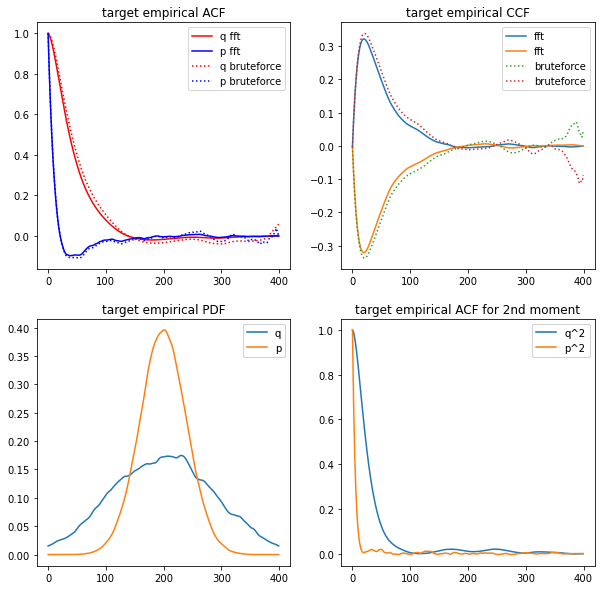

In [10]:
# Plotting target ACFs and PDF
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0,0].plot(loss_acf_fft._target.cpu()[...,0],'r', label='q fft')
axs[0,0].plot(loss_acf_fft._target.cpu()[...,1],'b', label='p fft')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,0],'r:', label= 'q bruteforce')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,1], 'b:', label='p bruteforce')
axs[0,0].legend()
axs[0,0].set_title('target empirical ACF')

axs[0,1].plot(loss_ccf_fft._target.cpu()[...,1:3], label='fft')
axs[0,1].plot(loss_ccf_bruteforce._target.cpu()[...,1:3],':',label='bruteforce')
# legend2 = axs[0,1].legend(iter(bf), ('q bf', 'p bf'), loc=1)
# axs[0,1].add_artist(legend2)
axs[0,1].legend()
axs[0,1].set_title('target empirical CCF')

x_grid=-np.linspace(-5,5,num=sec_length)
pdf = axs[1,0].plot(loss_pdf_empirical._target.cpu())
legend3 = axs[1,0].legend(iter(pdf), ('q', 'p'), loc=1)
axs[1,0].add_artist(legend3)
axs[1,0].set_title('target empirical PDF')


print(loss_acf_sec_moment._target.cpu().size())
sec_moment = axs[1,1].plot(loss_acf_sec_moment._target.cpu())
legend4 = axs[1,1].legend(iter(sec_moment), ('q^2', 'p^2'),loc=1)
axs[1,1].set_title('target empirical ACF for 2nd moment')
axs[1,1].add_artist(legend4)

plt.show()

Check analytical solution: $q\sim N(0, \dfrac{1}{k})$, $p\sim N(0,1)$

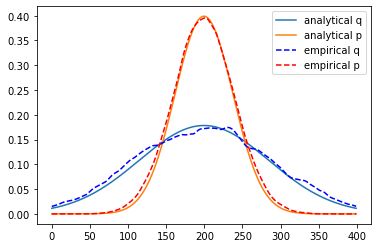

In [11]:
# plt.figure()

import scipy.stats as stats
import math
mu = 0
variance_q = 1/k  # variance of q
variance_p = 1    # variance of p
sigma1 = math.sqrt(variance_q)
sigma2 = math.sqrt(variance_p)
if k == 0.5:
    x = np.linspace(mu - 3.75 * sigma1, mu + 3.75 * sigma1, sec_length) #k=0.5
elif k == 0.25: 
    x = np.linspace(mu - 2.5 * sigma1, mu + 2.5 * sigma1, sec_length) #k=0.25
elif k == 0.2:
    x = np.linspace(mu - 2.35 * sigma1, mu + 2.35 * sigma1, sec_length) #k=0.2

plt.plot(stats.norm.pdf(x, mu, sigma1),label='analytical q')
plt.plot(stats.norm.pdf(x, mu, sigma2),label='analytical p')

plt.plot(loss_pdf_empirical._target.cpu()[...,0],'b--',label='empirical q')
plt.plot(loss_pdf_empirical._target.cpu()[...,1],'r--',label='empirical p')

# plt.title('analytical PDF vs target empirical PDF')
plt.legend()

Check analytical acf and ccf of p and q:$\left[ {\begin{array}{cc}
   acf(q) & ccf(q,p) \\
   ccf(p,q) & acf(p) \\
  \end{array} } \right]$
- if $4k<\gamma^2$:

$\left[ {\begin{array}{cc}
   \dfrac{e^{-\frac{\tau \gamma}{2}}[(-4k+\gamma^2)\cosh{\dfrac{\tau\sqrt{-4k+\gamma^2}}{2} }+\gamma\sqrt{-4k+\gamma^2}\sinh{\dfrac{\tau\sqrt{-4k+\gamma^2}}{2}}]}{k(-4k+\gamma^2)} & -\dfrac{2e^{-\frac{\tau \gamma}{2}}\sinh{\dfrac{\tau\sqrt{-4k+\gamma^2}}{2}}}{\sqrt{-4k+\gamma^2}} \\
   \dfrac{2e^{-\frac{\tau \gamma}{2}}\sinh{\dfrac{\tau\sqrt{-4k+\gamma^2}}{2}}}{\sqrt{-4k+\gamma^2}} & \dfrac{e^{-\frac{\tau}{2}(\gamma+\sqrt{-4k+\gamma^2})} \{-4(1+e^{\tau\sqrt{-4k+\gamma^2}})k+\gamma^2+\gamma[\sqrt{-4k+\gamma^2}+e^{\tau\sqrt{-4k+\gamma^2}}(\gamma-\sqrt{-4k+\gamma^2})]\}}{2(-4k+\gamma^2)} \\
  \end{array} } \right]$
  
- if $4k=\gamma^2$:

$\left[ {\begin{array}{cc}
   \dfrac{2(2+\tau\gamma)e^{-\frac{\tau\gamma}{2}}}{\gamma^2} & -e^{-\frac{\tau\gamma}{2}\tau} \\
   e^{-\frac{\tau\gamma}{2}\tau} & \dfrac{(2-\tau\gamma)e^{-\frac{\tau\gamma}{2}}}{2} \\
  \end{array} } \right]$
  
- if $4k>\gamma^2$:

$\left[ {\begin{array}{cc}
   \dfrac{e^{-\frac{\tau \gamma}{2}}[(-4k+\gamma^2)\cos{\dfrac{\tau\sqrt{4k-\gamma^2}}{2} }-\gamma\sqrt{4k-\gamma^2}\sin{\dfrac{\tau\sqrt{4k-\gamma^2}}{2}}]}{k(-4k+\gamma^2)} & -\dfrac{2e^{-\frac{\tau \gamma}{2}}\sin{\dfrac{\tau\sqrt{4k-\gamma^2}}{2}}}{\sqrt{4k-\gamma^2}} \\
   \dfrac{2e^{-\frac{\tau \gamma}{2}}\sin{\dfrac{\tau\sqrt{4k-\gamma^2}}{2}}}{\sqrt{4k-\gamma^2}} & \dfrac{e^{-\frac{\tau\gamma}{2}} [(\gamma^2-4k)\cos{\dfrac{\tau \sqrt{4k-\gamma^2}}{2}}+\gamma\sqrt{4k-\gamma^2}\sin{\dfrac{\tau \sqrt{4k-\gamma^2}}{2}}]}{-4k+\gamma^2} \\
  \end{array} } \right]$


In [12]:
def exact_acf_q(k, gamma, sec_length, variance):
    acf = np.zeros(sec_length)
    if k < .25 * gamma**2:
        delta = -4*k + gamma**2
        sqrt_delta = math.sqrt(delta)
        for tau in range(sec_length):
            lag = tau*0.1
            a = math.exp(-lag*gamma/2)
            b = delta*math.cosh(lag*sqrt_delta/2)+gamma*sqrt_delta*math.sinh(lag*sqrt_delta/2)
            c = k*delta
            acf[tau] = (a*b/c)/variance
    elif k == .25 * gamma**2:
        for tau in range(sec_length):
            lag = tau*0.1
            acf[tau] = 2 * math.exp(-lag*gamma/2) * (2+lag*gamma) / variance
    elif k > .25 * gamma**2:
        delta = 4*k - gamma**2
        sqrt_delta = math.sqrt(delta)
        for tau in range(sec_length):
            lag = tau*0.1
            a = math.exp(-lag*gamma/2)
            b = delta*math.cos(lag*sqrt_delta/2)+gamma*sqrt_delta*math.sin(lag*sqrt_delta/2)
            c = k*delta
            acf[tau] = (a*b/c)/variance
    return acf

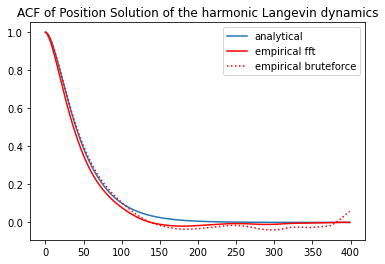

In [13]:
plt.plot(exact_acf_q(k, gamma, sec_length, variance_q),label='analytical')
plt.plot(loss_acf_fft._target.cpu()[...,0],'r', label='empirical fft')
plt.plot(loss_acf_bruteforce._target.cpu()[...,0],'r:', label='empirical bruteforce')
plt.title("ACF of Position Solution of the harmonic Langevin dynamics")
plt.legend()

In [14]:
def exact_acf_p(k, gamma, sec_length, variance):
    acf = np.zeros(sec_length)
    if k < .25 * gamma**2:
        delta = -4*k + gamma**2
        sqrt_delta = math.sqrt(delta)
        for tau in range(sec_length):
            lag = tau*.1
            a = math.exp(-lag*(gamma+sqrt_delta)/2)
            b = -4*(1+math.exp(lag*sqrt_delta))*k+gamma**2+gamma*(sqrt_delta+math.exp(lag*sqrt_delta)*(gamma-sqrt_delta))
            c = 2*delta
            acf[tau] = (a*b/c)/variance
    elif k == .25 * gamma**2:
        for tau in range(sec_length):
            lag = tau*.1
            acf[tau] = 1/2 * math.exp(-lag*gamma/2) * (2-lag*gamma) / variance
    elif k > .25 * gamma**2:
        delta = 4*k - gamma**2
        sqrt_delta = math.sqrt(delta)
        for tau in range(sec_length):
            lag = tau*.1
            a = math.exp(-lag*gamma/2)
            b = delta*math.cos(lag*sqrt_delta/2)-gamma*sqrt_delta*math.sin(lag*sqrt_delta/2)
            c = delta
            acf[tau] = (a*b/c)/variance
    return acf

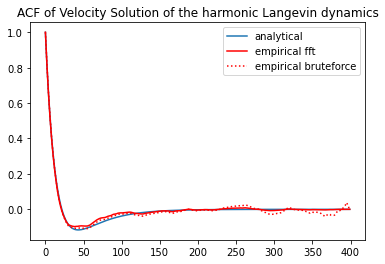

In [15]:
plt.plot(exact_acf_p(k, gamma, sec_length, variance_p), label='analytical')
plt.plot(loss_acf_fft._target.cpu()[...,1],'r', label='empirical fft')
plt.plot(loss_acf_bruteforce._target.cpu()[...,1],'r:', label='empirical bruteforce')
plt.title("ACF of Velocity Solution of the harmonic Langevin dynamics")
plt.legend()

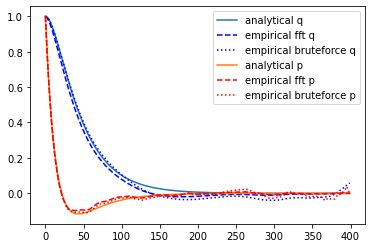

In [16]:
plt.plot(exact_acf_q(k, gamma, sec_length, variance_q),label='analytical q')
plt.plot(loss_acf_fft._target.cpu()[...,0],'b--', label='empirical fft q')
plt.plot(loss_acf_bruteforce._target.cpu()[...,0],'b:', label='empirical bruteforce q')
plt.plot(exact_acf_p(k, gamma, sec_length, variance_p), label='analytical p')
plt.plot(loss_acf_fft._target.cpu()[...,1],'r--', label='empirical fft p')
plt.plot(loss_acf_bruteforce._target.cpu()[...,1],'r:', label='empirical bruteforce p')
plt.legend()


In [17]:
def exact_acf_qp(k, gamma, sec_length, sigma_p, sigma_q):
    ccf = np.zeros(sec_length)
    if k < .25 * gamma**2:
        delta = -4*k + gamma**2
        sqrt_delta = math.sqrt(delta)
        for tau in range(sec_length):
            lag = tau*.1
            a = 2*math.exp(-lag*gamma/2)
            b = math.sinh(lag*sqrt_delta/2)
            c = sqrt_delta
            ccf[tau] = -(a*b/c)
    elif k == .25 * gamma**2:
        for tau in range(sec_length):
            lag = tau*.1
            ccf[tau] = - math.exp(-lag*gamma/2)*lag 
    elif k > .25 * gamma**2:
        delta = 4*k - gamma**2
        sqrt_delta = math.sqrt(delta)
        for tau in range(sec_length):
            lag = tau*.1
            a = 2*math.exp(-lag*gamma/2)
            b = math.sin(lag*sqrt_delta/2)
            c = sqrt_delta
            ccf[tau] = -(a*b/c)
    return ccf/(sigma_p*sigma_q)

In [18]:
def exact_acf_pq(k, gamma, sec_length, sigma_p, sigma_q):
    ccf = np.zeros(sec_length)
    if k < .25 * gamma**2:
        delta = -4*k + gamma**2
        sqrt_delta = math.sqrt(delta)
        for tau in range(sec_length):
            lag = tau*.1
            a = 2*math.exp(-lag*gamma/2)
            b = math.sinh(lag*sqrt_delta/2)
            c = sqrt_delta
            ccf[tau] = (a*b/c)
    elif k == .25 * gamma**2:
        for tau in range(sec_length):
            lag = tau*.1
            ccf[tau] = math.exp(-lag*gamma/2)*lag 
    elif k > .25 * gamma**2:
        delta = 4*k - gamma**2
        sqrt_delta = math.sqrt(delta)
        for tau in range(sec_length):
            lag = tau*.1
            a = 2*math.exp(-lag*gamma/2)
            b = math.sin(lag*sqrt_delta/2)
            c = sqrt_delta
            ccf[tau] = (a*b/c)
    return ccf/(sigma_p*sigma_q)

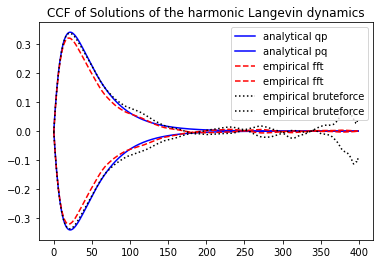

In [19]:
plt.plot(exact_acf_qp(k, gamma, sec_length,sigma1,sigma2),'b', label='analytical qp')
plt.plot(exact_acf_pq(k, gamma, sec_length,sigma1,sigma2), 'b', label='analytical pq')
plt.plot(loss_ccf_fft._target.cpu()[...,1:3],'r--',label='empirical fft')
plt.plot(loss_ccf_bruteforce._target.cpu()[...,1:3],'k:',label='empirical bruteforce')
plt.title("CCF of Solutions of the harmonic Langevin dynamics")
plt.legend()

Text(0.5, 1.0, 'target empirical CCF for 2nd moment')

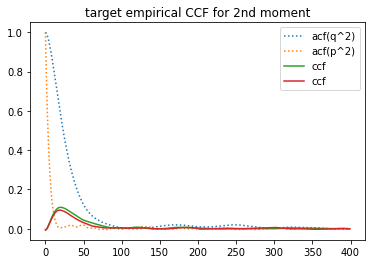

In [20]:
plt.plot(loss_ccf_sec_moment._target.cpu()[...,0],':',label='acf(q^2)')
plt.plot(loss_ccf_sec_moment._target.cpu()[...,3],':',label='acf(p^2)')
plt.plot(loss_ccf_sec_moment._target.cpu()[...,1:3],label='ccf')
plt.legend()
plt.title("target empirical CCF for 2nd moment")

## 1.1. Loss function=ACF($\textbf{x}$)+PDF($\textbf{x}$)+ACF($\textbf{x}^2$)

In [28]:
### Defining SINN model
net = SINN(1, 5, 2, 2).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [29]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_acf_fft(prediction) + loss_pdf_empirical(prediction) + loss_acf_sec_moment(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_empirical(pred_val) + loss_acf_sec_moment(pred_val**2)
            loss_val_acf = loss_acf_bruteforce(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.001 and loss_val<=0.001:
            break
print('Training finished')

[0]-th step loss: 0.329, 0.332
[50]-th step loss: 0.307, 0.311
[100]-th step loss: 0.199, 0.195
[150]-th step loss: 0.086, 0.088
[200]-th step loss: 0.054, 0.057
[250]-th step loss: 0.041, 0.044
[300]-th step loss: 0.033, 0.036
[350]-th step loss: 0.027, 0.030
[400]-th step loss: 0.024, 0.026
[450]-th step loss: 0.021, 0.024
[500]-th step loss: 0.019, 0.022
[550]-th step loss: 0.017, 0.020
[600]-th step loss: 0.016, 0.018
[650]-th step loss: 0.015, 0.017
[700]-th step loss: 0.013, 0.015
[750]-th step loss: 0.010, 0.012
[800]-th step loss: 0.007, 0.008
[850]-th step loss: 0.006, 0.007
[900]-th step loss: 0.006, 0.007
[950]-th step loss: 0.005, 0.006
[1000]-th step loss: 0.004, 0.005
[1050]-th step loss: 0.004, 0.005
[1100]-th step loss: 0.003, 0.005
[1150]-th step loss: 0.003, 0.004
[1200]-th step loss: 0.003, 0.004
[1250]-th step loss: 0.003, 0.004
[1300]-th step loss: 0.003, 0.004
[1350]-th step loss: 0.002, 0.004
[1400]-th step loss: 0.002, 0.004
[1450]-th step loss: 0.002, 0.003
[15

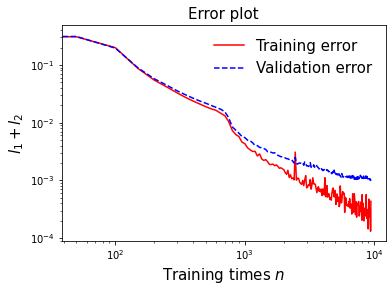

In [30]:
### ACF
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

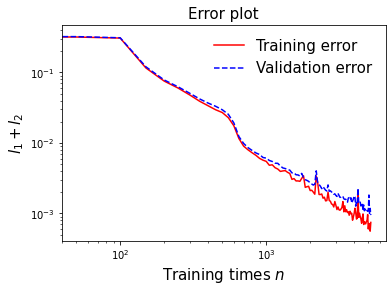

In [28]:
### ACF
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [31]:
# # Gaussian random input
ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
Pred,_= net(ran_input)
prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)

([<matplotlib.axis.YTick at 0x152d75f85760>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

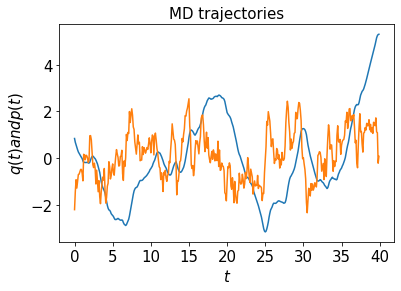

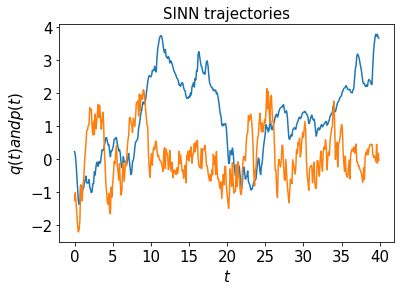

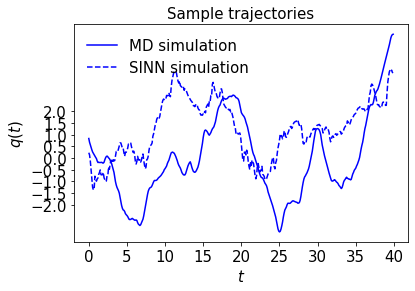

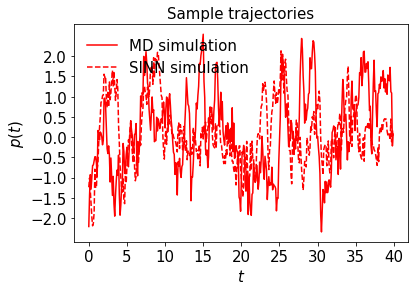

In [49]:
# Test 1: plot the sample path generated by SINN and the exact sample path 
skip = 0

fig = plt.figure(0)
plt.title("MD trajectories",fontsize=15) 
plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t) and p(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15) 
# plt.savefig("figs/FPU_traj_multi_MD.pdf", dpi=150)

fig = plt.figure(1)
plt.title("SINN trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], prediction[skip:, 8])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t) and p(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/FPU_traj_multi.pdf", dpi=150)


fig = plt.figure(2)
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 0, 0],'b', label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 8, 0],'b--',label='SINN simulation')
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)

fig = plt.figure(3)
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 0, 1],'r', label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 8, 1],'r--',label='SINN simulation')
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)

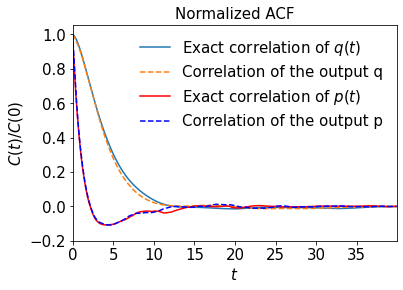

In [53]:
# Test 2: plot the ACF of the sample path generated by the SINN and the exact ACF  

acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
acf_t=StatLoss.acf(target)
# corr_p=acf_p.mean(axis=1).detach().cpu().numpy()
# corr_t=acf_t.mean(axis=1).detach().cpu().numpy()
corr_p=acf_p.detach().cpu().numpy()
corr_t=acf_t.detach().cpu().numpy()


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, corr_t[...,0],'',label=r'Exact correlation of $q(t)$')        # correlation function of the target 
plt.plot(T, corr_p[...,0], '--',label=r'Correlation of the output q')        # Correlation function after the training      # Correlation function after the training 
plt.plot(T, corr_t[...,1],'r',label=r'Exact correlation of $p(t)$')        # correlation function of the target 
plt.plot(T, corr_p[...,1], 'b--',label=r'Correlation of the output p')        # Correlation function after the training      # Correlation function after the training 

plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.xlim(0,T[-1])
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

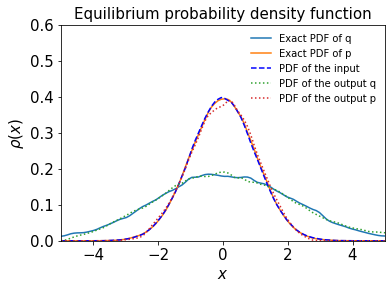

In [55]:
# Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
rho_data =  StatLoss.gauss_kde(target, -5, 5, 100).cpu()
rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100).cpu()
rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100).cpu()


x=np.linspace(-5, 5, 100)
fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r"Equilibrium probability density function",fontsize=15)    
plt.plot(x, rho_data.numpy()[...,0],label=r'Exact PDF of q')    # target PDF
plt.plot(x, rho_data.numpy()[...,1],label=r'Exact PDF of p')    # target PDF
plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
plt.plot(x, rho_prediction.numpy()[...,0], ':',label=r'PDF of the output q')  # PDF after the training 
plt.plot(x, rho_prediction.numpy()[...,1], ':',label=r'PDF of the output p')  # PDF after the training 
plt.xlim(-5,5)
plt.ylim(0,0.6)
plt.xlabel(r'$x$',fontsize=15)
plt.ylabel(r'$\rho(x)$',fontsize=15)
plt.legend(frameon=False,fontsize=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

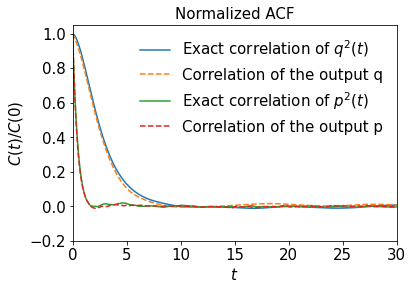

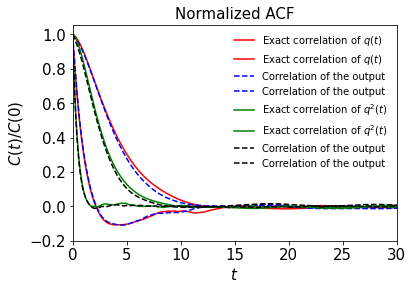

In [52]:
# Test 4: Comparing the higher-order ACF
acf2=StatLoss.acf(target**2)
pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,2))
acf2_app=StatLoss.acf(pred_norm**2)

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
# plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'r',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
# plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'g--',label=r'Correlation of the output')        # Correlation function after the training 
plt.plot(T, acf2.detach().cpu().numpy()[...,0],label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.detach().cpu().numpy()[...,0], '--',label=r'Correlation of the output q')        # Correlation function after the training 
plt.plot(T, acf2.detach().cpu().numpy()[...,1],label=r'Exact correlation of $p^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.detach().cpu().numpy()[...,1], '--',label=r'Correlation of the output p')        # Correlation function after the training 
plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/FPU_acf2.pdf", dpi=150)


fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)  
plt.plot(T, corr_t,'r',label=r'Exact correlation of $q(t)$')        # correlation function of the target 
plt.plot(T, corr_p, 'b--',label=r'Correlation of the output')   
# plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'g',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
# plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'k--',label=r'Correlation of the output')        # Correlation function after the training 
plt.plot(T, acf2.detach().cpu().numpy(),'g',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.detach().cpu().numpy(), 'k--',label=r'Correlation of the output')        # Correlation function after the training 
plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=10)

(array([  0., 100., 200., 300., 400., 500.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

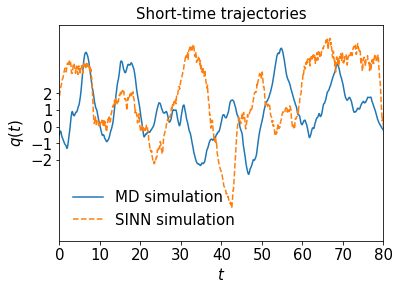

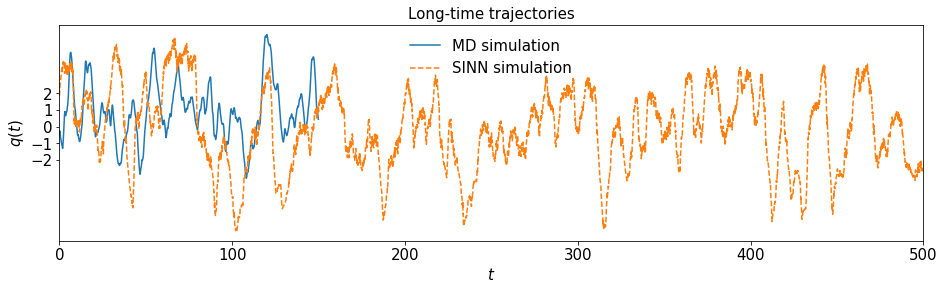

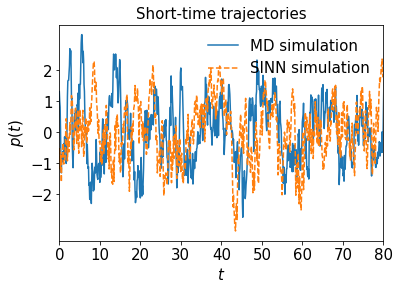

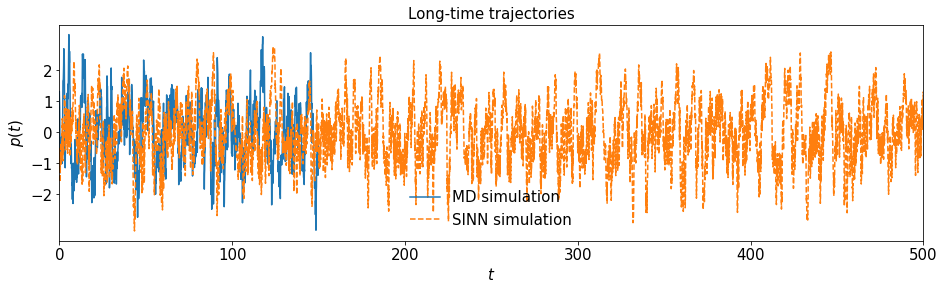

In [30]:
# Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 
[a,b,c]=input.size()
skip=20
scale=10
burnin=3
fold=800
batch_new=50
ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
Pred_L, _= net(ran_input)
prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new,2)
acf_p=StatLoss.acf(Pred_L,method='bruteforce')

LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
LT=LT[0:-1]


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Short-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 1,0],'--',label='SINN simulation')
plt.xlim([0,80])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/FPU_traj_sT.pdf", dpi=150)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Long-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 1,0],'--',label='SINN simulation')
plt.xlim([0,500])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)

fig = plt.figure(2)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Short-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],p_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 1,1],'--',label='SINN simulation')
plt.xlim([0,80])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/FPU_traj_sT.pdf", dpi=150)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Long-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],p_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 1,1],'--',label='SINN simulation')
plt.xlim([0,500])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)

## 1.2. Loss function=CCF($\textbf{x}$)+PDF($\textbf{x}$)+CCF($\textbf{x}^2$)

In [56]:
### Defining SINN model
net = SINN(1, 5, 2, 2).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [57]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_ccf_fft(prediction) + loss_pdf_empirical(prediction) + loss_ccf_sec_moment(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical(pred_val) + loss_ccf_sec_moment(pred_val**2)
            loss_val_ccf = loss_ccf_bruteforce(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.001 and loss_val<=0.001:
            break
print('Training finished')

[0]-th step loss: 0.308, 0.311
[50]-th step loss: 0.301, 0.304
[100]-th step loss: 0.282, 0.283
[150]-th step loss: 0.277, 0.278
[200]-th step loss: 0.270, 0.271
[250]-th step loss: 0.093, 0.095
[300]-th step loss: 0.052, 0.054
[350]-th step loss: 0.039, 0.042
[400]-th step loss: 0.034, 0.036
[450]-th step loss: 0.031, 0.032
[500]-th step loss: 0.027, 0.029
[550]-th step loss: 0.024, 0.027
[600]-th step loss: 0.023, 0.026
[650]-th step loss: 0.022, 0.024
[700]-th step loss: 0.020, 0.022
[750]-th step loss: 0.020, 0.022
[800]-th step loss: 0.018, 0.020
[850]-th step loss: 0.017, 0.019
[900]-th step loss: 0.011, 0.012
[950]-th step loss: 0.008, 0.009
[1000]-th step loss: 0.007, 0.008
[1050]-th step loss: 0.006, 0.007
[1100]-th step loss: 0.006, 0.006
[1150]-th step loss: 0.005, 0.006
[1200]-th step loss: 0.005, 0.005
[1250]-th step loss: 0.004, 0.005
[1300]-th step loss: 0.004, 0.005
[1350]-th step loss: 0.004, 0.004
[1400]-th step loss: 0.004, 0.004
[1450]-th step loss: 0.004, 0.004
[15

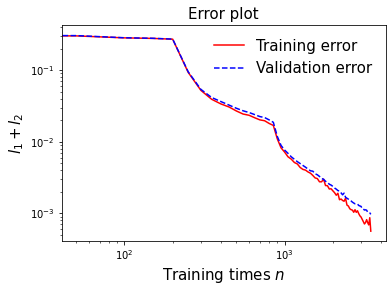

In [58]:
### CCF
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [60]:
# # Gaussian random input
ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
Pred,_= net(ran_input)
prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)

([<matplotlib.axis.YTick at 0x152d041e3e20>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

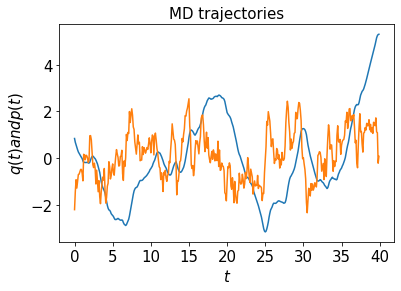

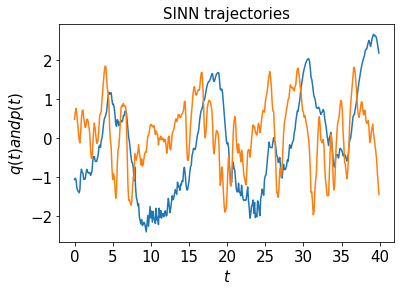

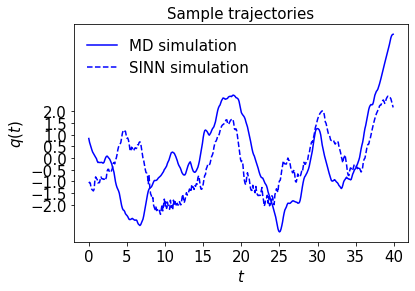

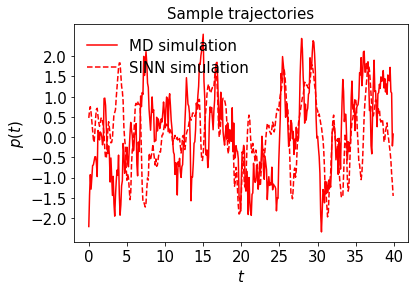

In [65]:
# Test 1: plot the sample path generated by SINN and the exact sample path 
skip = 0

fig = plt.figure(0)
plt.title("MD trajectories",fontsize=15) 
plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t) and p(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15) 
# plt.savefig("figs/FPU_traj_multi_MD.pdf", dpi=150)

fig = plt.figure(1)
plt.title("SINN trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], prediction[skip:, 7])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t) and p(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/FPU_traj_multi.pdf", dpi=150)


fig = plt.figure(2)
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 0,0], 'b',label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 7,0],'b--',label='SINN simulation')
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)

fig = plt.figure(3)
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 0,1],'r', label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 7,1],'r--',label='SINN simulation')
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)

([<matplotlib.axis.YTick at 0x14ec814f76a0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

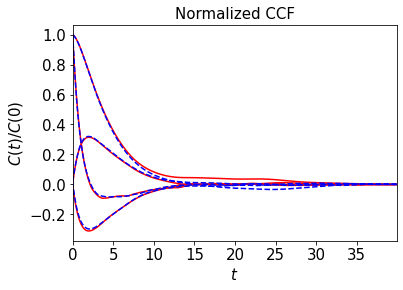

In [28]:
# Test 2: plot the ACF of the sample path generated by the SINN and the exact CCF  

ccf_p=StatLoss.ccf(Pred[-sec_length:,:,:])
ccf_t=StatLoss.ccf(target)
corr_p=ccf_p.detach().cpu().numpy()
corr_t=ccf_t.detach().cpu().numpy()


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized CCF',fontsize=15)    
plt.plot(T, corr_t,'r')        # correlation function of the target 
plt.plot(T, corr_p, 'b--')        # Correlation function after the training      # Correlation function after the training 
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.xlim(0,T[-1])
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
# plt.legend(frameon=False,fontsize=15)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

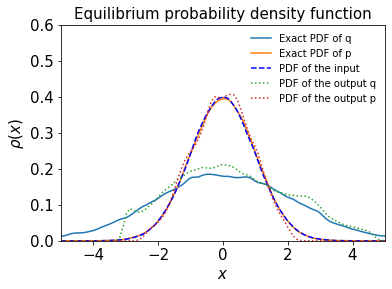

In [66]:
# Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
rho_data =  StatLoss.gauss_kde(target, -5, 5, 100).cpu()
rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100).cpu()
rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100).cpu()


x=np.linspace(-5, 5, 100)
fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r"Equilibrium probability density function",fontsize=15)    
plt.plot(x, rho_data.numpy()[...,0],label=r'Exact PDF of q')    # target PDF
plt.plot(x, rho_data.numpy()[...,1],label=r'Exact PDF of p')    # target PDF
plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
plt.plot(x, rho_prediction.numpy()[...,0], ':',label=r'PDF of the output q')  # PDF after the training 
plt.plot(x, rho_prediction.numpy()[...,1], ':',label=r'PDF of the output p')  # PDF after the training 
plt.xlim(-5,5)
plt.ylim(0,0.6)
plt.xlabel(r'$x$',fontsize=15)
plt.ylabel(r'$\rho(x)$',fontsize=15)
plt.legend(frameon=False,fontsize=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

([<matplotlib.axis.YTick at 0x152d30109c70>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

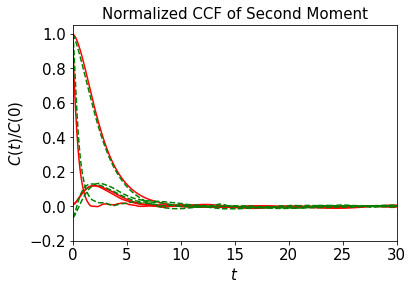

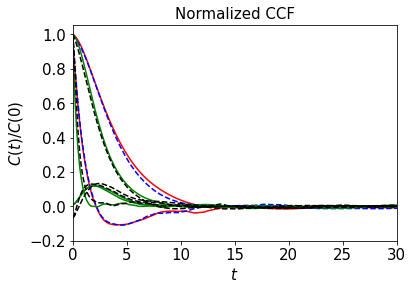

In [68]:
# Test 4: Comparing the higher-order CCF
ccf2=StatLoss.ccf(target**2)
pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,2))
ccf2_app=StatLoss.ccf(pred_norm**2)

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized CCF of Second Moment',fontsize=15)    
plt.plot(T, ccf2.detach().cpu().numpy(),'r',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
plt.plot(T, ccf2_app.detach().cpu().numpy(), 'g--',label=r'Correlation of the output')        # Correlation function after the training 

plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
# plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/FPU_acf2.pdf", dpi=150)


fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized CCF',fontsize=15)  
plt.plot(T, corr_t,'r',label=r'Exact correlation of $q(t)$')        # correlation function of the target 
plt.plot(T, corr_p, 'b--',label=r'Correlation of the output')   
# plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'g',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
# plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'k--',label=r'Correlation of the output')        # Correlation function after the training 
plt.plot(T, ccf2.detach().cpu().numpy(),'g',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
plt.plot(T, ccf2_app.detach().cpu().numpy(), 'k--',label=r'Correlation of the output')        # Correlation function after the training 
plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
# plt.legend(frameon=False,fontsize=10)

(array([  0., 100., 200., 300., 400., 500.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

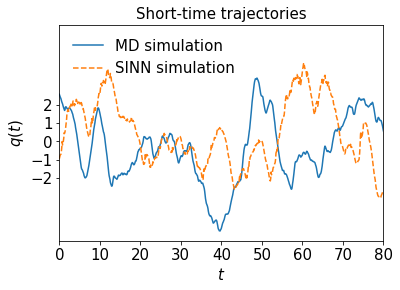

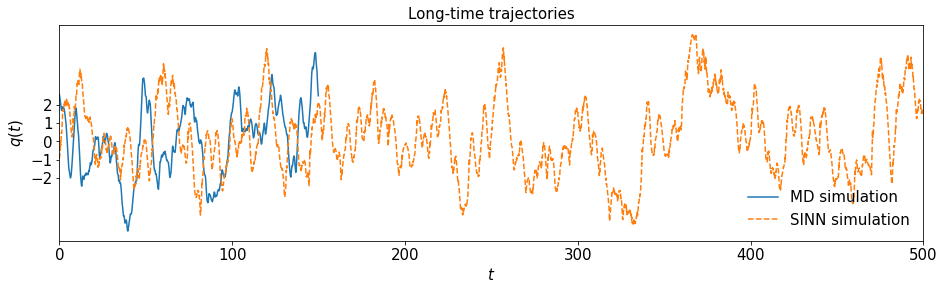

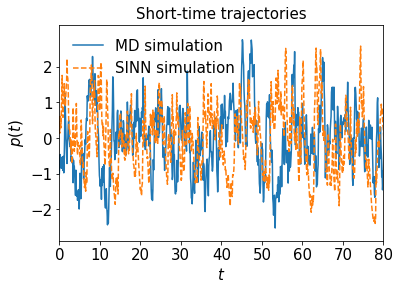

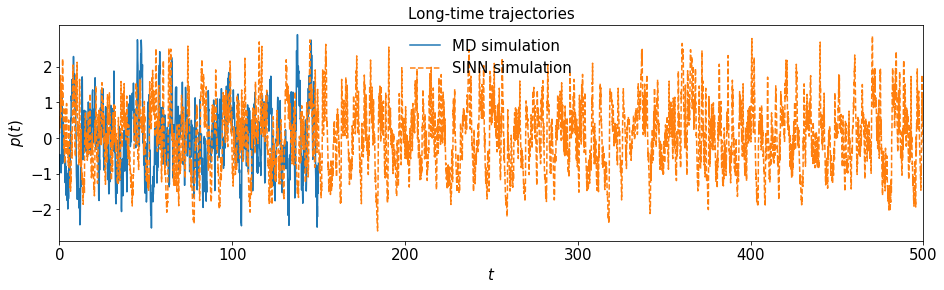

In [31]:
# Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 
[a,b,c]=input.size()
skip=20
scale=10
burnin=3
fold=800
batch_new=50
ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
Pred_L, _= net(ran_input)
prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new,2)
ccf_p=StatLoss.ccf(Pred_L,method='bruteforce')

LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
LT=LT[0:-1]


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Short-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
plt.xlim([0,80])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/FPU_traj_sT.pdf", dpi=150)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Long-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
plt.xlim([0,500])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)

fig = plt.figure(2)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Short-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],p_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
plt.xlim([0,80])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/FPU_traj_sT.pdf", dpi=150)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Long-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],p_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
plt.xlim([0,500])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)

## 1.3. Loss function=CCF($\textbf{x}$)+PDF($\textbf{x}$)+ACF($\textbf{x}^2$)

In [21]:
### Defining SINN model
net = SINN(1, 5, 2, 2).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [22]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_ccf_fft(prediction) + loss_pdf_empirical(prediction) + loss_acf_sec_moment(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical(pred_val) + loss_acf_sec_moment(pred_val**2)
            loss_val_ccf = loss_ccf_bruteforce(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.001 and loss_val<=0.001:
            break
print('Training finished')

[0]-th step loss: 0.314, 0.317
[50]-th step loss: 0.303, 0.306
[100]-th step loss: 0.139, 0.136
[150]-th step loss: 0.083, 0.086
[200]-th step loss: 0.064, 0.067
[250]-th step loss: 0.047, 0.050
[300]-th step loss: 0.036, 0.039
[350]-th step loss: 0.029, 0.031
[400]-th step loss: 0.017, 0.018
[450]-th step loss: 0.014, 0.015
[500]-th step loss: 0.013, 0.013
[550]-th step loss: 0.011, 0.012
[600]-th step loss: 0.009, 0.010
[650]-th step loss: 0.009, 0.010
[700]-th step loss: 0.011, 0.016
[750]-th step loss: 0.008, 0.009
[800]-th step loss: 0.007, 0.008
[850]-th step loss: 0.007, 0.008
[900]-th step loss: 0.007, 0.008
[950]-th step loss: 0.007, 0.007
[1000]-th step loss: 0.006, 0.007
[1050]-th step loss: 0.006, 0.007
[1100]-th step loss: 0.006, 0.007
[1150]-th step loss: 0.006, 0.006
[1200]-th step loss: 0.005, 0.006
[1250]-th step loss: 0.005, 0.006
[1300]-th step loss: 0.006, 0.006
[1350]-th step loss: 0.005, 0.005
[1400]-th step loss: 0.004, 0.005
[1450]-th step loss: 0.004, 0.005
[15

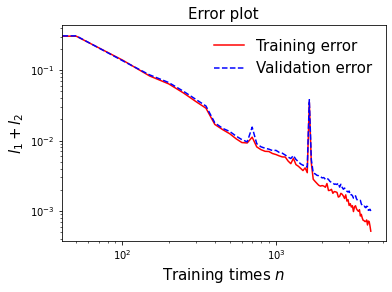

In [23]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [24]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_ccf_fft(prediction) + loss_pdf_empirical(prediction) + loss_acf_sec_moment(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical(pred_val) + loss_acf_sec_moment(pred_val**2)
            loss_val_ccf = loss_ccf_bruteforce(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.001 and loss_val<=0.001:
            break
print('Training finished')

[0]-th step loss: 0.313, 0.316
[50]-th step loss: 0.281, 0.282
[100]-th step loss: 0.168, 0.170
[150]-th step loss: 0.078, 0.079
[200]-th step loss: 0.047, 0.049
[250]-th step loss: 0.033, 0.033
[300]-th step loss: 0.023, 0.024
[350]-th step loss: 0.018, 0.018
[400]-th step loss: 0.015, 0.016
[450]-th step loss: 0.013, 0.013
[500]-th step loss: 0.011, 0.012
[550]-th step loss: 0.011, 0.011
[600]-th step loss: 0.009, 0.010
[650]-th step loss: 0.008, 0.009
[700]-th step loss: 0.007, 0.008
[750]-th step loss: 0.007, 0.007
[800]-th step loss: 0.006, 0.006
[850]-th step loss: 0.005, 0.005
[900]-th step loss: 0.005, 0.005
[950]-th step loss: 0.005, 0.005
[1000]-th step loss: 0.004, 0.004
[1050]-th step loss: 0.004, 0.004
[1100]-th step loss: 0.003, 0.004
[1150]-th step loss: 0.003, 0.004
[1200]-th step loss: 0.003, 0.003
[1250]-th step loss: 0.003, 0.003
[1300]-th step loss: 0.002, 0.003
[1350]-th step loss: 0.002, 0.003
[1400]-th step loss: 0.002, 0.003
[1450]-th step loss: 0.002, 0.002
[15

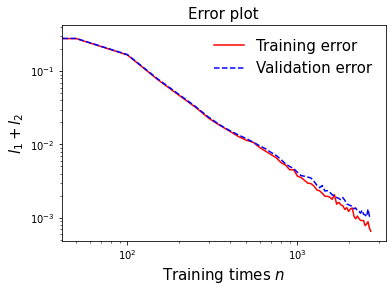

In [25]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [24]:
# # Gaussian random input
ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
Pred,_= net(ran_input)
prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)

([<matplotlib.axis.YTick at 0x1511e93798b0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

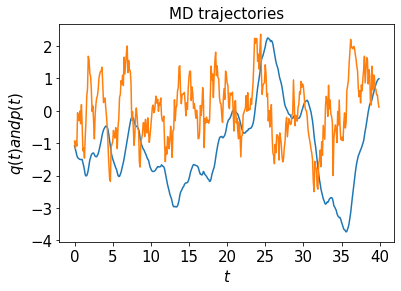

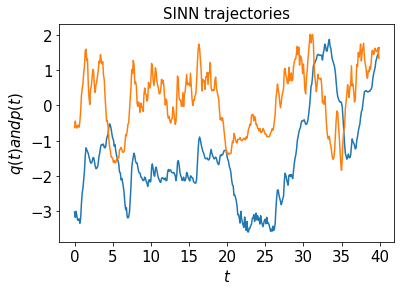

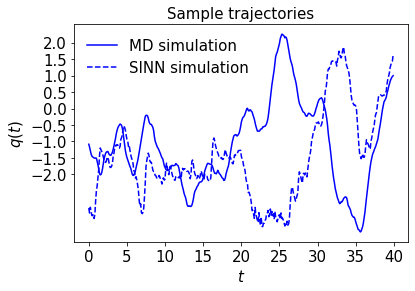

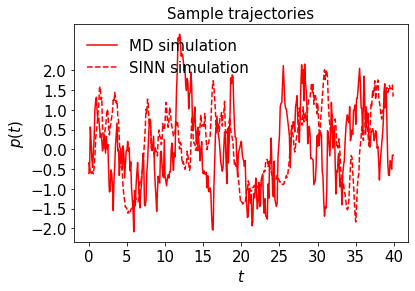

In [48]:
# Test 1: plot the sample path generated by SINN and the exact sample path 
skip = 0

fig = plt.figure(0)
plt.title("MD trajectories",fontsize=15) 
plt.plot(T[skip:]-T[skip], Traj[skip:, 5])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t) and p(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15) 
# plt.savefig("figs/FPU_traj_multi_MD.pdf", dpi=150)

fig = plt.figure(1)
plt.title("SINN trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], prediction[skip:, 2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t) and p(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/FPU_traj_multi.pdf", dpi=150)


fig = plt.figure(2)
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:,5, 0], 'b',label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 2, 0],'b--',label='SINN simulation')
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)

fig = plt.figure(3)
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 2, 1],'r', label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 2, 1],'r--',label='SINN simulation')
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)

([<matplotlib.axis.YTick at 0x15124123ba90>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

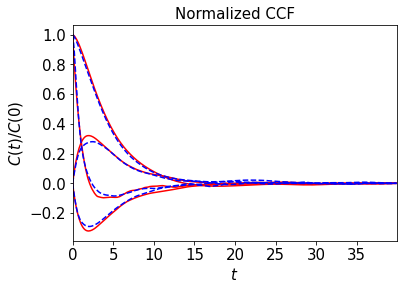

In [29]:
# Test 2: plot the ACF of the sample path generated by the SINN and the exact ACF  

ccf_p=StatLoss.ccf(Pred[-sec_length:,:,:])
ccf_t=StatLoss.ccf(target)
corr_p=ccf_p.detach().cpu().numpy()
corr_t=ccf_t.detach().cpu().numpy()


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized CCF',fontsize=15)    
plt.plot(T, corr_t,'r')        # correlation function of the target 
plt.plot(T, corr_p, 'b--')        # Correlation function after the training      # Correlation function after the training 
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.xlim(0,T[-1])
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

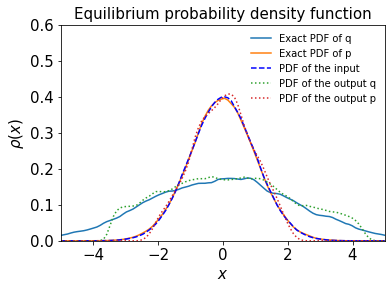

In [30]:
# Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
rho_data =  StatLoss.gauss_kde(target, -5, 5, 100).cpu()
rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100).cpu()
rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100).cpu()


x=np.linspace(-5, 5, 100)
fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r"Equilibrium probability density function",fontsize=15)    
plt.plot(x, rho_data.numpy()[...,0],label=r'Exact PDF of q')    # target PDF
plt.plot(x, rho_data.numpy()[...,1],label=r'Exact PDF of p')    # target PDF
plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
plt.plot(x, rho_prediction.numpy()[...,0], ':',label=r'PDF of the output q')  # PDF after the training 
plt.plot(x, rho_prediction.numpy()[...,1], ':',label=r'PDF of the output p')  # PDF after the training 
plt.xlim(-5,5)
plt.ylim(0,0.6)
plt.xlabel(r'$x$',fontsize=15)
plt.ylabel(r'$\rho(x)$',fontsize=15)
plt.legend(frameon=False,fontsize=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

([<matplotlib.axis.YTick at 0x151240082130>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

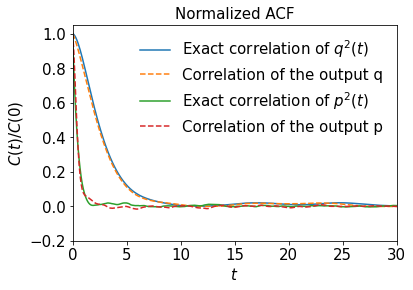

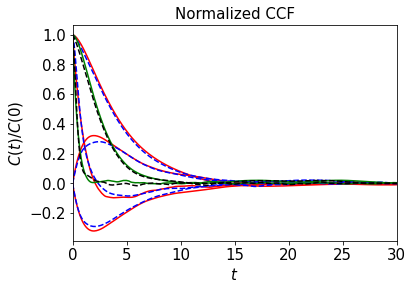

In [35]:
# Test 4: Comparing the higher-order ACF
acf2=StatLoss.acf(target**2)
pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,2))
acf2_app=StatLoss.acf(pred_norm**2)

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, acf2.detach().cpu().numpy()[...,0],'',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.detach().cpu().numpy()[...,0], '--',label=r'Correlation of the output q')        # Correlation function after the training 
plt.plot(T, acf2.detach().cpu().numpy()[...,1],'',label=r'Exact correlation of $p^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.detach().cpu().numpy()[...,1], '--',label=r'Correlation of the output p')        # Correlation function after the training 

plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/FPU_acf2.pdf", dpi=150)


fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized CCF',fontsize=15)  
plt.plot(T, corr_t,'r',label=r'Exact correlation of $q(t)$')        # correlation function of the target 
plt.plot(T, corr_p, 'b--',label=r'Correlation of the output')   
# plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'g',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
# plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'k--',label=r'Correlation of the output')        # Correlation function after the training 
plt.plot(T, acf2.detach().cpu().numpy(),'g',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.detach().cpu().numpy(), 'k--',label=r'Correlation of the output')        # Correlation function after the training 
plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)

(array([  0., 100., 200., 300., 400., 500.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

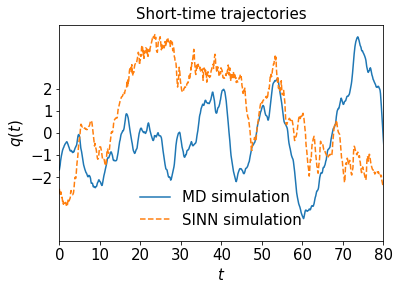

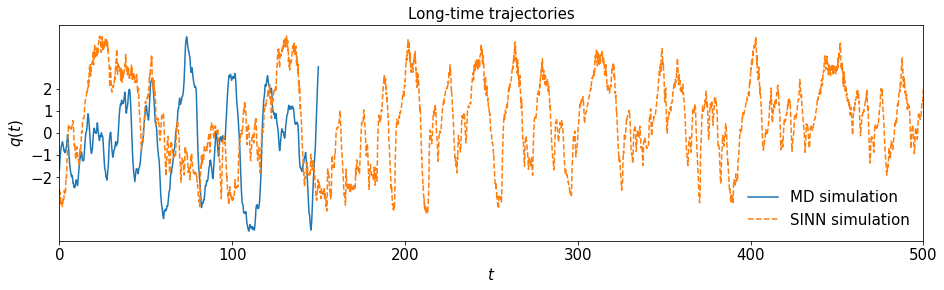

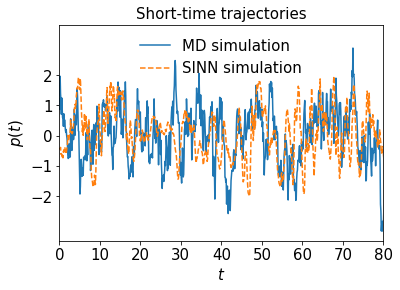

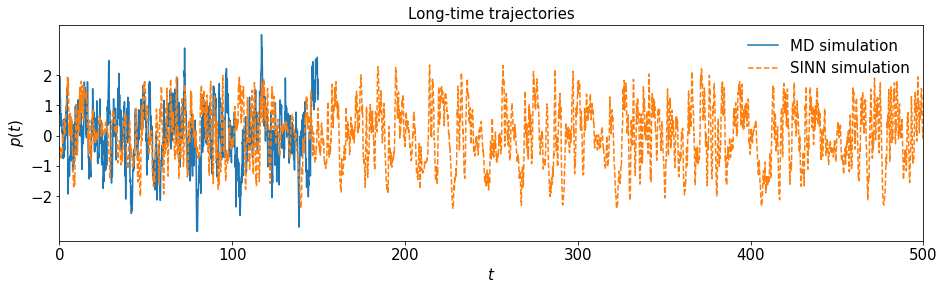

In [36]:
# Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 
[a,b,c]=input.size()
skip=20
scale=10
burnin=3
fold=800
batch_new=50
ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
Pred_L, _= net(ran_input)
prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new,2)
ccf_p=StatLoss.ccf(Pred_L,method='bruteforce')

LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
LT=LT[0:-1]


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Short-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
plt.xlim([0,80])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/FPU_traj_sT.pdf", dpi=150)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Long-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
plt.xlim([0,500])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)

fig = plt.figure(2)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Short-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],p_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
plt.xlim([0,80])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/FPU_traj_sT.pdf", dpi=150)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Long-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],p_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
plt.xlim([0,500])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)

# 2. 2 inputs

In [8]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,2*batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 2)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 2), device=device)


Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 2]) torch.float32
The torch validation size is torch.Size([800, 400, 2]) torch.float32
The torch target size is torch.Size([400, 400, 2]) torch.float32


In [9]:
# Defining Loss functions
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_sec_moment = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_ccf_fft = make_loss('ccf[fft]', target, lags=LAGS, device=device)
loss_ccf_sec_moment = make_loss('ccf[fft]', target**2, lags=LAGS, device=device)
loss_ccf_bruteforce = make_loss('ccf[bruteforce]', target, lags=LAGS, device=device)
loss_ccf_randbrute = make_loss('ccf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_pdf_empirical = make_loss('pdf', target, lower=-5, upper=5, n=N, device=device)

## 2.1. Loss function=ACF($\textbf{x}$)+PDF($\textbf{x}$)+ACF($\textbf{x}^2$)

In [51]:
### Defining SINN model
net = SINN(2, 5, 2, 2).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [11]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,2*batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,2)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_acf_fft(prediction) + loss_pdf_empirical(prediction) + loss_acf_sec_moment(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_empirical(pred_val) + loss_acf_sec_moment(pred_val**2)
            loss_val_acf = loss_acf_bruteforce(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.001 and loss_val<=0.001:
            break
print('Training finished')

[0]-th step loss: 0.325, 0.329
[50]-th step loss: 0.311, 0.314
[100]-th step loss: 0.220, 0.218
[150]-th step loss: 0.065, 0.068
[200]-th step loss: 0.049, 0.050
[250]-th step loss: 0.032, 0.032
[300]-th step loss: 0.019, 0.019
[350]-th step loss: 0.015, 0.015
[400]-th step loss: 0.013, 0.013
[450]-th step loss: 0.011, 0.012
[500]-th step loss: 0.010, 0.010
[550]-th step loss: 0.009, 0.009
[600]-th step loss: 0.008, 0.009
[650]-th step loss: 0.007, 0.008
[700]-th step loss: 0.007, 0.007
[750]-th step loss: 0.006, 0.007
[800]-th step loss: 0.007, 0.006
[850]-th step loss: 0.006, 0.006
[900]-th step loss: 0.005, 0.005
[950]-th step loss: 0.005, 0.005
[1000]-th step loss: 0.005, 0.005
[1050]-th step loss: 0.004, 0.004
[1100]-th step loss: 0.004, 0.004
[1150]-th step loss: 0.004, 0.004
[1200]-th step loss: 0.003, 0.004
[1250]-th step loss: 0.003, 0.003
[1300]-th step loss: 0.003, 0.003
[1350]-th step loss: 0.003, 0.003
[1400]-th step loss: 0.002, 0.003
[1450]-th step loss: 0.002, 0.003
[15

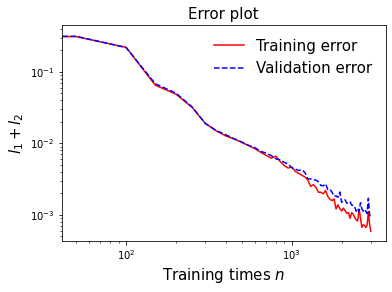

In [12]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [54]:
# # Gaussian random input
ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
Pred,_= net(ran_input)
prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)

([<matplotlib.axis.YTick at 0x1511e5116430>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

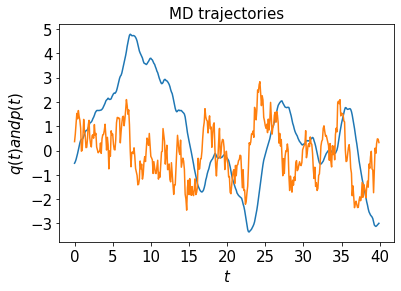

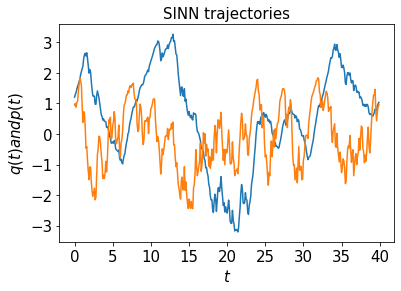

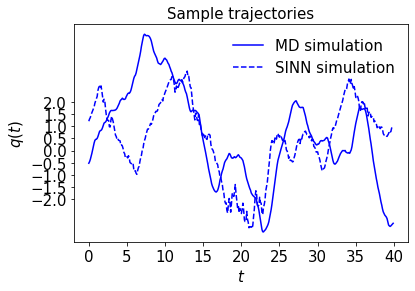

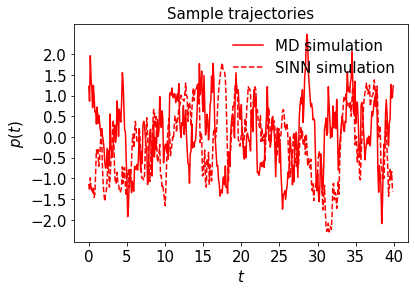

In [62]:
# Test 1: plot the sample path generated by SINN and the exact sample path 
skip = 0

fig = plt.figure(0)
plt.title("MD trajectories",fontsize=15) 
plt.plot(T[skip:]-T[skip], Traj[skip:, 6])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t) and p(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.ylim((-6,4))
# plt.savefig("figs/FPU_traj_multi_MD.pdf", dpi=150)

fig = plt.figure(1)
plt.title("SINN trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], prediction[skip:, 4])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t) and p(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.ylim((-6,4))
# plt.savefig("figs/FPU_traj_multi.pdf", dpi=150)


fig = plt.figure(2)
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 6, 0], 'b',label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 4, 0],'b--',label='SINN simulation')
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)

fig = plt.figure(3)
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 0, 1],'r', label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 0, 1],'r--',label='SINN simulation')
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)

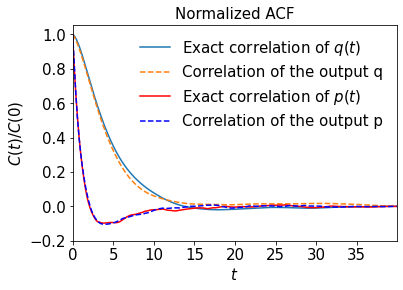

In [63]:
# Test 2: plot the ACF of the sample path generated by the SINN and the exact ACF  

acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
acf_t=StatLoss.acf(target)
corr_p=acf_p.detach().cpu().numpy()
corr_t=acf_t.detach().cpu().numpy()

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, corr_t[...,0],'',label=r'Exact correlation of $q(t)$')        # correlation function of the target 
plt.plot(T, corr_p[...,0], '--',label=r'Correlation of the output q')        # Correlation function after the training      # Correlation function after the training 
plt.plot(T, corr_t[...,1],'r',label=r'Exact correlation of $p(t)$')        # correlation function of the target 
plt.plot(T, corr_p[...,1], 'b--',label=r'Correlation of the output p')        # Correlation function after the training      # Correlation function after the training 

plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.xlim(0,T[-1])
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)

# fig = plt.figure(0)
# ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
# plt.title(r'Normalized CCF',fontsize=15)    
# plt.plot(T, corr_t,'r')        # correlation function of the target 
# plt.plot(T, corr_p, 'b--')        # Correlation function after the training      # Correlation function after the training 
# plt.xlabel(r'$t$',fontsize=15)
# plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
# plt.xticks(fontsize=15)
# plt.xlim(0,T[-1])
# plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

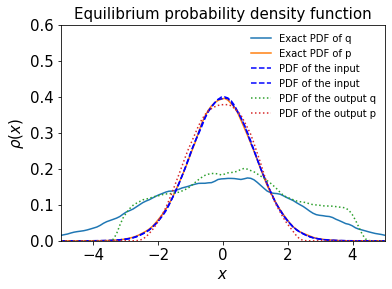

In [64]:
# Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
rho_data =  StatLoss.gauss_kde(target, -5, 5, 100).cpu()
rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100).cpu()
rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100).cpu()


x=np.linspace(-5, 5, 100)
fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r"Equilibrium probability density function",fontsize=15)    
plt.plot(x, rho_data.numpy()[...,0],label=r'Exact PDF of q')    # target PDF
plt.plot(x, rho_data.numpy()[...,1],label=r'Exact PDF of p')    # target PDF
plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
plt.plot(x, rho_prediction.numpy()[...,0], ':',label=r'PDF of the output q')  # PDF after the training 
plt.plot(x, rho_prediction.numpy()[...,1], ':',label=r'PDF of the output p')  # PDF after the training 
plt.xlim(-5,5)
plt.ylim(0,0.6)
plt.xlabel(r'$x$',fontsize=15)
plt.ylabel(r'$\rho(x)$',fontsize=15)
plt.legend(frameon=False,fontsize=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

([<matplotlib.axis.YTick at 0x1511e4ee8f70>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

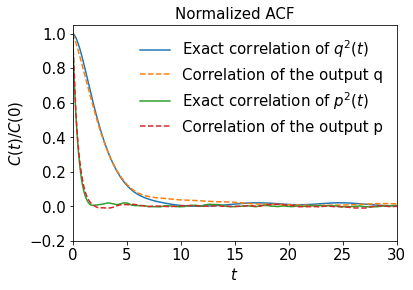

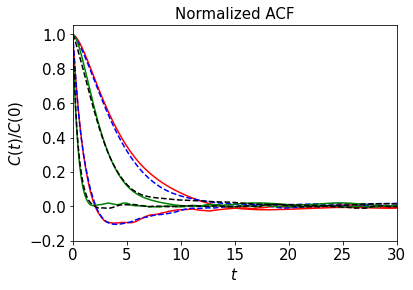

In [65]:
# Test 4: Comparing the higher-order ACF
acf2=StatLoss.acf(target**2)
pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,2))
acf2_app=StatLoss.acf(pred_norm**2)

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, acf2.detach().cpu().numpy()[...,0],'',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.detach().cpu().numpy()[...,0], '--',label=r'Correlation of the output q')        # Correlation function after the training 
plt.plot(T, acf2.detach().cpu().numpy()[...,1],'',label=r'Exact correlation of $p^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.detach().cpu().numpy()[...,1], '--',label=r'Correlation of the output p')        # Correlation function after the training 

plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/FPU_acf2.pdf", dpi=150)


fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)  
plt.plot(T, corr_t,'r',label=r'Exact correlation of $q(t)$')        # correlation function of the target 
plt.plot(T, corr_p, 'b--',label=r'Correlation of the output')   
# plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'g',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
# plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'k--',label=r'Correlation of the output')        # Correlation function after the training 
plt.plot(T, acf2.detach().cpu().numpy(),'g',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.detach().cpu().numpy(), 'k--',label=r'Correlation of the output')        # Correlation function after the training 
plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)

(array([  0., 100., 200., 300., 400., 500.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

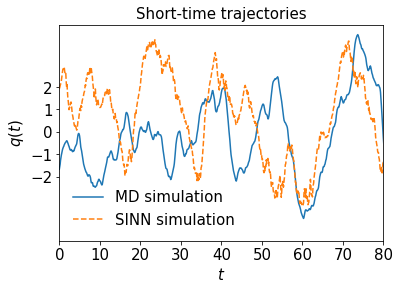

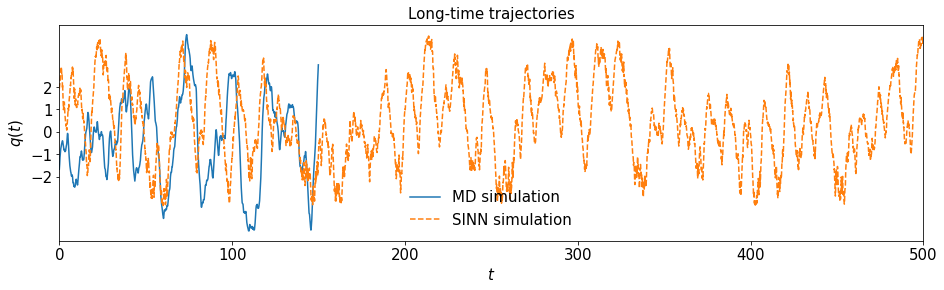

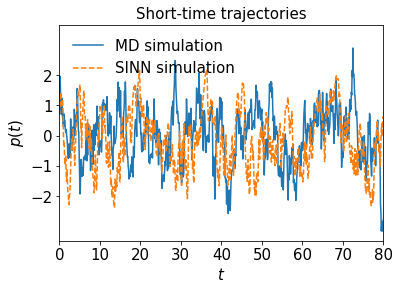

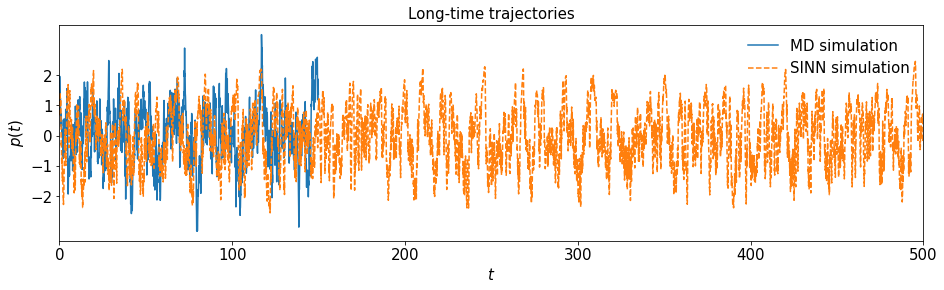

In [66]:
# Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 
[a,b,c]=input.size()
skip=20
scale=10
burnin=3
fold=800
batch_new=50
ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
Pred_L, _= net(ran_input)
prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new,2)
ccf_p=StatLoss.ccf(Pred_L,method='bruteforce')

LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
LT=LT[0:-1]


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Short-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
plt.xlim([0,80])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/FPU_traj_sT.pdf", dpi=150)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Long-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
plt.xlim([0,500])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)

fig = plt.figure(2)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Short-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],p_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
plt.xlim([0,80])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/FPU_traj_sT.pdf", dpi=150)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Long-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],p_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
plt.xlim([0,500])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)

## 2.2. Loss function=CCF($\textbf{x}$)+PDF($\textbf{x}$)+CCF($\textbf{x}^2$)

In [10]:
### Defining SINN model
net = SINN(2, 5, 2, 2).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [11]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,2*batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,2)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_ccf_fft(prediction) + loss_pdf_empirical(prediction) + loss_ccf_sec_moment(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical(pred_val) + loss_ccf_sec_moment(pred_val**2)
            loss_val_acf = loss_acf_bruteforce(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.001 and loss_val<=0.001:
            break
print('Training finished')

[0]-th step loss: 0.305, 0.309
[50]-th step loss: 0.289, 0.292
[100]-th step loss: 0.166, 0.167
[150]-th step loss: 0.051, 0.052
[200]-th step loss: 0.031, 0.032
[250]-th step loss: 0.023, 0.024
[300]-th step loss: 0.018, 0.018
[350]-th step loss: 0.014, 0.015
[400]-th step loss: 0.012, 0.012
[450]-th step loss: 0.010, 0.011
[500]-th step loss: 0.009, 0.010
[550]-th step loss: 0.007, 0.008
[600]-th step loss: 0.006, 0.007
[650]-th step loss: 0.006, 0.007
[700]-th step loss: 0.005, 0.006
[750]-th step loss: 0.005, 0.006
[800]-th step loss: 0.004, 0.005
[850]-th step loss: 0.004, 0.005
[900]-th step loss: 0.004, 0.005
[950]-th step loss: 0.003, 0.004
[1000]-th step loss: 0.003, 0.004
[1050]-th step loss: 0.003, 0.004
[1100]-th step loss: 0.003, 0.004
[1150]-th step loss: 0.003, 0.004
[1200]-th step loss: 0.003, 0.003
[1250]-th step loss: 0.003, 0.003
[1300]-th step loss: 0.002, 0.003
[1350]-th step loss: 0.002, 0.003
[1400]-th step loss: 0.002, 0.003
[1450]-th step loss: 0.003, 0.005
[15

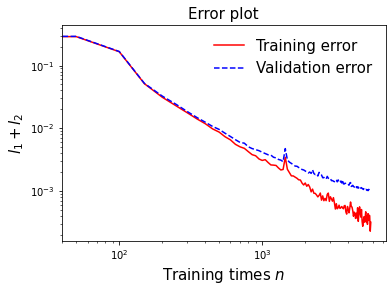

In [12]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [13]:
# # Gaussian random input
ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
Pred,_= net(ran_input)
prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)

([<matplotlib.axis.YTick at 0x1532b311c700>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

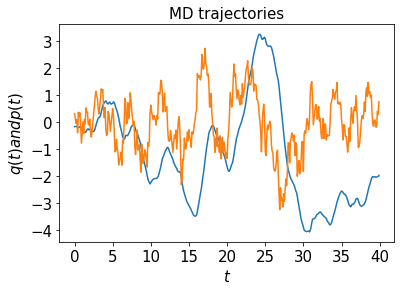

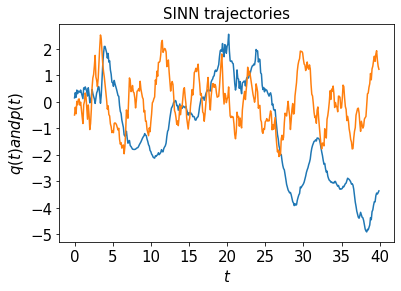

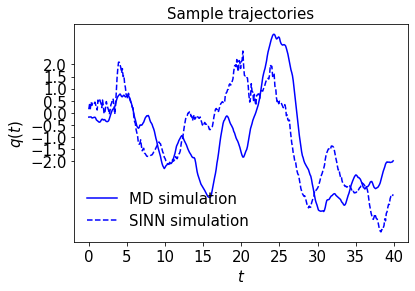

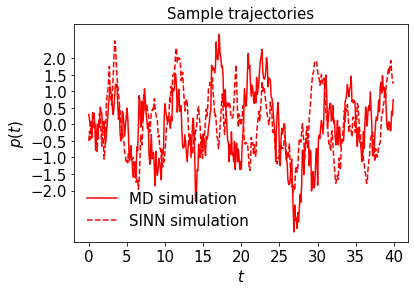

In [20]:
# Test 1: plot the sample path generated by SINN and the exact sample path 
skip = 0

fig = plt.figure(0)
plt.title("MD trajectories",fontsize=15) 
plt.plot(T[skip:]-T[skip], Traj[skip:, 1])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t) and p(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15) 
# plt.savefig("figs/FPU_traj_multi_MD.pdf", dpi=150)

fig = plt.figure(1)
plt.title("SINN trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], prediction[skip:, 2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t) and p(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/FPU_traj_multi.pdf", dpi=150)


fig = plt.figure(2)
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 1,0], 'b',label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 2,0],'b--',label='SINN simulation')
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)

fig = plt.figure(3)
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 1,1],'r', label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 2,1],'r--',label='SINN simulation')
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)

([<matplotlib.axis.YTick at 0x1532b30f6220>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

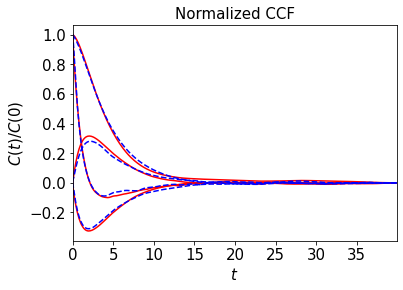

In [21]:
# Test 2: plot the ACF of the sample path generated by the SINN and the exact CCF  

ccf_p=StatLoss.ccf(Pred[-sec_length:,:,:])
ccf_t=StatLoss.ccf(target)
corr_p=ccf_p.detach().cpu().numpy()
corr_t=ccf_t.detach().cpu().numpy()


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized CCF',fontsize=15)    
plt.plot(T, corr_t,'r')        # correlation function of the target 
plt.plot(T, corr_p, 'b--')        # Correlation function after the training      # Correlation function after the training 
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.xlim(0,T[-1])
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

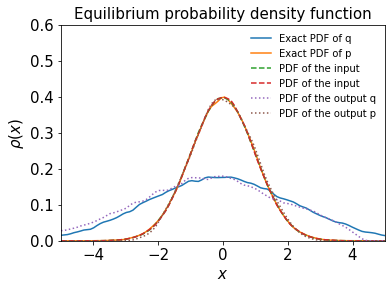

In [22]:
# Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
rho_data =  StatLoss.gauss_kde(target, -5, 5, 100).cpu()
rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100).cpu()
rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100).cpu()


x=np.linspace(-5, 5, 100)
fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r"Equilibrium probability density function",fontsize=15)    
plt.plot(x, rho_data.numpy()[...,0],label=r'Exact PDF of q')    # target PDF
plt.plot(x, rho_data.numpy()[...,1],label=r'Exact PDF of p')    # target PDF
plt.plot(x, rho_input.numpy(), '--', label=r'PDF of the input')     # PDF of the input
plt.plot(x, rho_prediction.numpy()[...,0], ':',label=r'PDF of the output q')  # PDF after the training 
plt.plot(x, rho_prediction.numpy()[...,1], ':',label=r'PDF of the output p')  # PDF after the training 
plt.xlim(-5,5)
plt.ylim(0,0.6)
plt.xlabel(r'$x$',fontsize=15)
plt.ylabel(r'$\rho(x)$',fontsize=15)
plt.legend(frameon=False,fontsize=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

([<matplotlib.axis.YTick at 0x1532b1acdb50>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

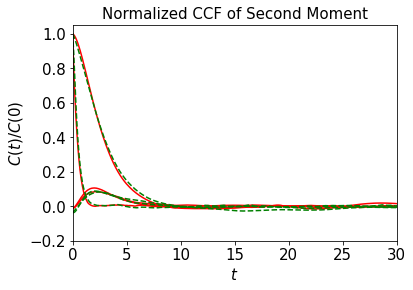

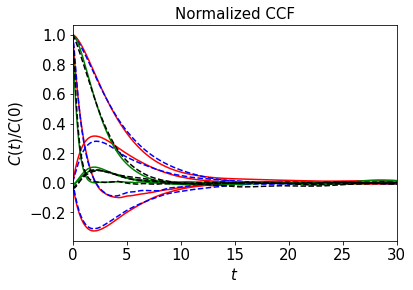

In [23]:
# Test 4: Comparing the higher-order CCF
ccf2=StatLoss.ccf(target**2)
pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,2))
ccf2_app=StatLoss.ccf(pred_norm**2)

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized CCF of Second Moment',fontsize=15)    
plt.plot(T, ccf2.detach().cpu().numpy(),'r',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
plt.plot(T, ccf2_app.detach().cpu().numpy(), 'g--',label=r'Correlation of the output')        # Correlation function after the training 

plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
# plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/FPU_acf2.pdf", dpi=150)


fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized CCF',fontsize=15)  
plt.plot(T, corr_t,'r',label=r'Exact correlation of $q(t)$')        # correlation function of the target 
plt.plot(T, corr_p, 'b--',label=r'Correlation of the output')   
# plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'g',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
# plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'k--',label=r'Correlation of the output')        # Correlation function after the training 
plt.plot(T, ccf2.detach().cpu().numpy(),'g',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
plt.plot(T, ccf2_app.detach().cpu().numpy(), 'k--',label=r'Correlation of the output')        # Correlation function after the training 
plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
# plt.legend(frameon=False,fontsize=10)

(array([  0., 100., 200., 300., 400., 500.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

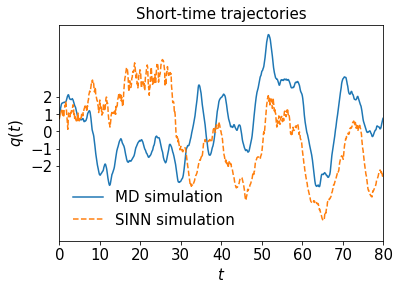

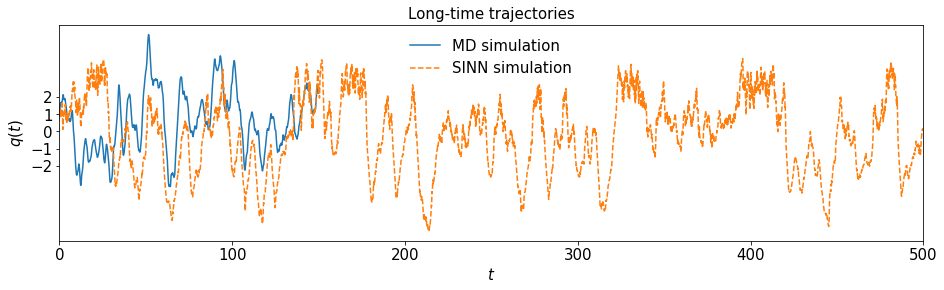

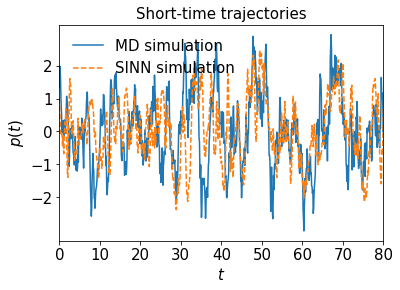

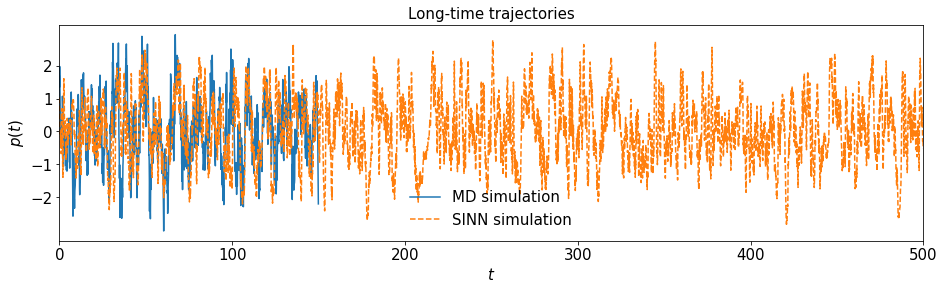

In [24]:
# Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 
[a,b,c]=input.size()
skip=20
scale=10
burnin=3
fold=800
batch_new=50
ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
Pred_L, _= net(ran_input)
prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new,2)
ccf_p=StatLoss.ccf(Pred_L,method='bruteforce')

LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
LT=LT[0:-1]


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Short-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
plt.xlim([0,80])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/FPU_traj_sT.pdf", dpi=150)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Long-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
plt.xlim([0,500])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)

fig = plt.figure(2)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Short-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],p_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
plt.xlim([0,80])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/FPU_traj_sT.pdf", dpi=150)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Long-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],p_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
plt.xlim([0,500])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)

## 2.3. Loss function=CCF($\textbf{x}$)+PDF($\textbf{x}$)+ACF($\textbf{x}^2$)

In [10]:
### Defining SINN model
net = SINN(2, 5, 2, 2).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [11]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,2*batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,2)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_ccf_fft(prediction) + loss_pdf_empirical(prediction) + loss_acf_sec_moment(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical(pred_val) + loss_acf_sec_moment(pred_val**2)
            loss_val_acf = loss_acf_bruteforce(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.001 and loss_val<=0.001:
            break
print('Training finished')

[0]-th step loss: 0.316, 0.319
[50]-th step loss: 0.296, 0.298
[100]-th step loss: 0.131, 0.130
[150]-th step loss: 0.058, 0.061
[200]-th step loss: 0.048, 0.052
[250]-th step loss: 0.043, 0.046
[300]-th step loss: 0.039, 0.043
[350]-th step loss: 0.036, 0.040
[400]-th step loss: 0.034, 0.038
[450]-th step loss: 0.031, 0.035
[500]-th step loss: 0.029, 0.033
[550]-th step loss: 0.027, 0.031
[600]-th step loss: 0.026, 0.030
[650]-th step loss: 0.025, 0.029
[700]-th step loss: 0.025, 0.028
[750]-th step loss: 0.024, 0.028
[800]-th step loss: 0.024, 0.027
[850]-th step loss: 0.023, 0.027
[900]-th step loss: 0.023, 0.026
[950]-th step loss: 0.023, 0.026
[1000]-th step loss: 0.022, 0.026
[1050]-th step loss: 0.022, 0.025
[1100]-th step loss: 0.022, 0.025
[1150]-th step loss: 0.021, 0.025
[1200]-th step loss: 0.021, 0.024
[1250]-th step loss: 0.020, 0.023
[1300]-th step loss: 0.019, 0.022
[1350]-th step loss: 0.016, 0.018
[1400]-th step loss: 0.011, 0.012
[1450]-th step loss: 0.009, 0.010
[15

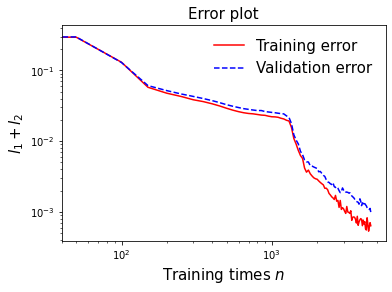

In [12]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [13]:
# # Gaussian random input
ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
Pred,_= net(ran_input)
prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)

([<matplotlib.axis.YTick at 0x14ed11d84160>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

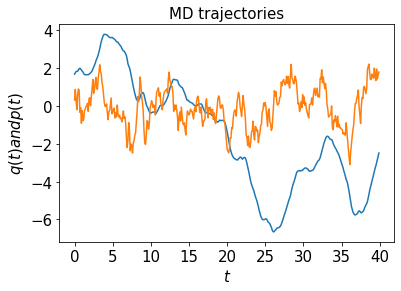

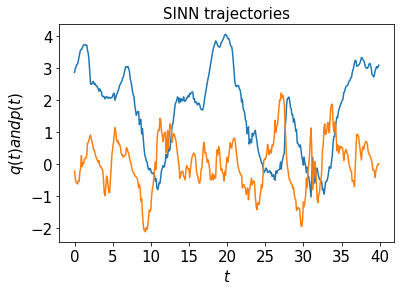

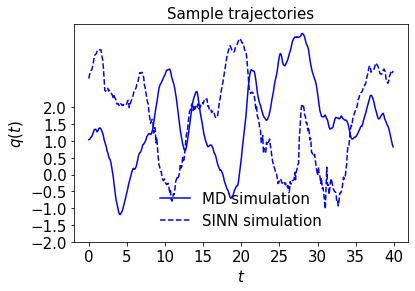

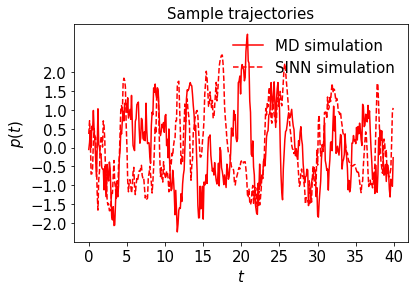

In [42]:
# Test 1: plot the sample path generated by SINN and the exact sample path 
skip = 0

fig = plt.figure(0)
plt.title("MD trajectories",fontsize=15) 
plt.plot(T[skip:]-T[skip], Traj[skip:, 6])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t) and p(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.ylim((-6,4))
# plt.savefig("figs/FPU_traj_multi_MD.pdf", dpi=150)

fig = plt.figure(1)
plt.title("SINN trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], prediction[skip:, 5])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t) and p(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.ylim((-6,4))
# plt.savefig("figs/FPU_traj_multi.pdf", dpi=150)


fig = plt.figure(2)
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 4, 0], 'b',label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 5, 0],'b--',label='SINN simulation')
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)

fig = plt.figure(3)
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 4, 1],'r', label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 7, 1],'r--',label='SINN simulation')
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)

([<matplotlib.axis.YTick at 0x14ed117cfd90>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

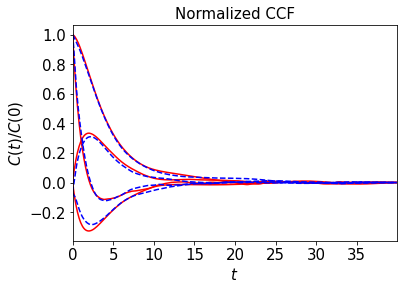

In [43]:
# Test 2: plot the ACF of the sample path generated by the SINN and the exact ACF  

ccf_p=StatLoss.ccf(Pred[-sec_length:,:,:])
ccf_t=StatLoss.ccf(target)
corr_p=ccf_p.detach().cpu().numpy()
corr_t=ccf_t.detach().cpu().numpy()


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized CCF',fontsize=15)    
plt.plot(T, corr_t,'r')        # correlation function of the target 
plt.plot(T, corr_p, 'b--')        # Correlation function after the training      # Correlation function after the training 
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.xlim(0,T[-1])
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

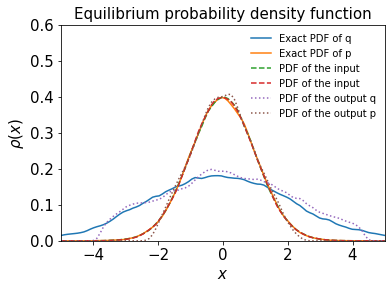

In [44]:
# Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
rho_data =  StatLoss.gauss_kde(target, -5, 5, 100).cpu()
rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100).cpu()
rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100).cpu()


x=np.linspace(-5, 5, 100)
fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r"Equilibrium probability density function",fontsize=15)    
plt.plot(x, rho_data.numpy()[...,0],label=r'Exact PDF of q')    # target PDF
plt.plot(x, rho_data.numpy()[...,1],label=r'Exact PDF of p')    # target PDF
plt.plot(x, rho_input.numpy(), '--', label=r'PDF of the input')     # PDF of the input
plt.plot(x, rho_prediction.numpy()[...,0], ':',label=r'PDF of the output q')  # PDF after the training 
plt.plot(x, rho_prediction.numpy()[...,1], ':',label=r'PDF of the output p')  # PDF after the training 
plt.xlim(-5,5)
plt.ylim(0,0.6)
plt.xlabel(r'$x$',fontsize=15)
plt.ylabel(r'$\rho(x)$',fontsize=15)
plt.legend(frameon=False,fontsize=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

([<matplotlib.axis.YTick at 0x14ed10081280>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

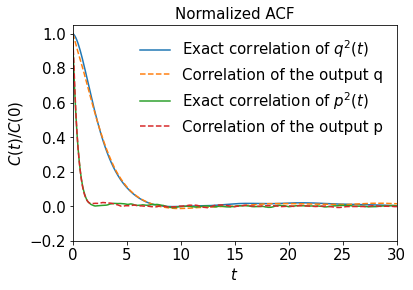

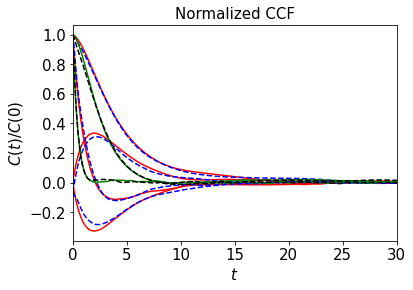

In [45]:
# Test 4: Comparing the higher-order ACF
acf2=StatLoss.acf(target**2)
pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,2))
acf2_app=StatLoss.acf(pred_norm**2)

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, acf2.detach().cpu().numpy()[...,0],'',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.detach().cpu().numpy()[...,0], '--',label=r'Correlation of the output q')        # Correlation function after the training 
plt.plot(T, acf2.detach().cpu().numpy()[...,1],'',label=r'Exact correlation of $p^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.detach().cpu().numpy()[...,1], '--',label=r'Correlation of the output p')        # Correlation function after the training 

plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/FPU_acf2.pdf", dpi=150)


fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized CCF',fontsize=15)  
plt.plot(T, corr_t,'r',label=r'Exact correlation of $q(t)$')        # correlation function of the target 
plt.plot(T, corr_p, 'b--',label=r'Correlation of the output')   
# plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'g',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
# plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'k--',label=r'Correlation of the output')        # Correlation function after the training 
plt.plot(T, acf2.detach().cpu().numpy(),'g',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.detach().cpu().numpy(), 'k--',label=r'Correlation of the output')        # Correlation function after the training 
plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)

(array([  0., 100., 200., 300., 400., 500.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

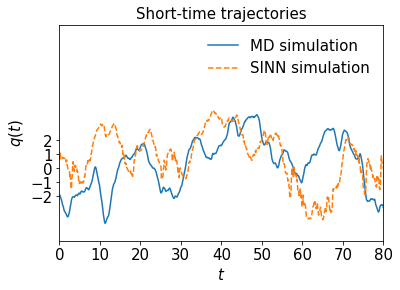

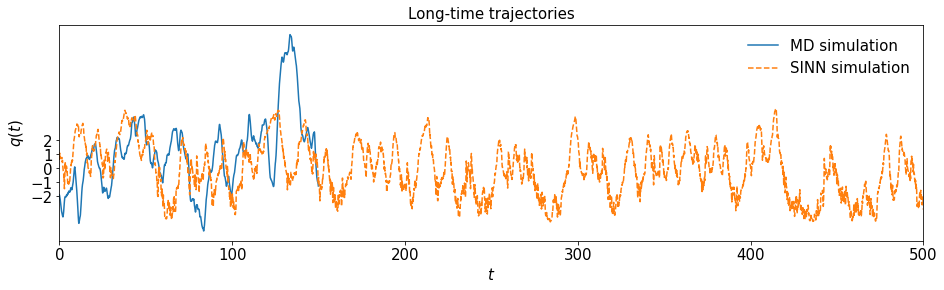

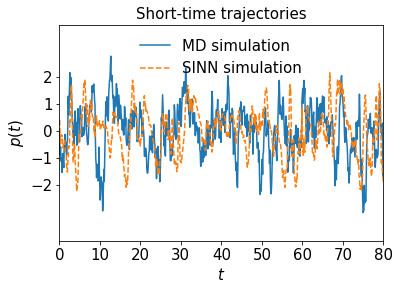

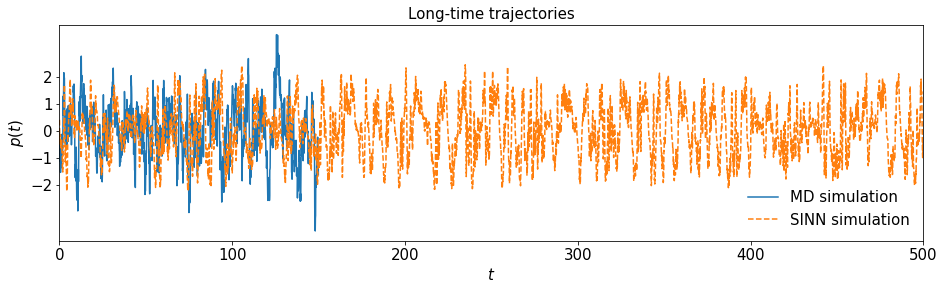

In [46]:
# Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 
[a,b,c]=input.size()
skip=20
scale=10
burnin=3
fold=800
batch_new=50
ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
Pred_L, _= net(ran_input)
prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new,2)
ccf_p=StatLoss.ccf(Pred_L,method='bruteforce')

LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
LT=LT[0:-1]


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Short-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
plt.xlim([0,80])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/FPU_traj_sT.pdf", dpi=150)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Long-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
plt.xlim([0,500])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)

fig = plt.figure(2)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Short-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],p_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
plt.xlim([0,80])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/FPU_traj_sT.pdf", dpi=150)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Long-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],p_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
plt.xlim([0,500])
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$p(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)